# Supervised Classification Algorithms

## Name: Jair Luiz de Azevedo Filho
## Chosen algorithms: Linear Discriminant Analysis, and Classification Tree (Random Tree Forests)

## This notebook is organized as follows: First, the data matrix is imported and the classifier terms are changed from [low,med,high] to [0,1,2]. Thus, the Linear Discriminant Analysis(LDA) is proposed as first classifier due to its low complexity. Then, due to its optimal way to split the data, a classification tree is proposed.



In [ ]:
#Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn import datasets
from numpy import genfromtxt


my_data = genfromtxt('df_data.csv', delimiter=',')    #Importing the data matrix from the file 'df_data.csv'
X = np.ones((np.size(my_data,axis=0)-1,3))            #Initialization of the matrix X
y = 3*np.ones((np.size(my_data,axis=0)-1,1))          #Initialization of the vector Y
for i in range(0,(np.size(my_data,axis=0)-1)):        #Filling the matrix X with the first three columns of 'my_data'
        X[i][:]=my_data[i+1][0:3]
    
with open('df_data.csv') as csvfile:                  # Switching the classifier values from [low,med,high] to [0,1,2]
        my_data_2 = csv.reader(csvfile)  
        i=0
        next(my_data_2)
        for line in my_data_2:
            if line[3]== 'med':
                y[i]=1
            elif line[3]=='low':
                y[i]=0
            else:
                y[i]=2
            i=i+1
            
#At this point, we have a (10000x3) matrix A and a (10000x1) classifier vector y. Thus, the classification methods 
#can be evalueated

## Linear Discriminant Analysis: A short Overview

### Linear Discriminant Analysis (for short, LDA) is a classification method that uses Singular Value Decomposition to find the directions that maximize the distances between the classes. It is important to stress that this method differs from Principal Component Analysis (PCA) since this latter tries to maximize the variance between the samples while LDA tries to maximize the separation between the classes.  After computing the linear discriminants, the samples are projected in this subspace, and thus, the classification occurs.
### This method is well-known in Classification tasks due to simple and low-complexity application. For this reason, this method was chosen. 

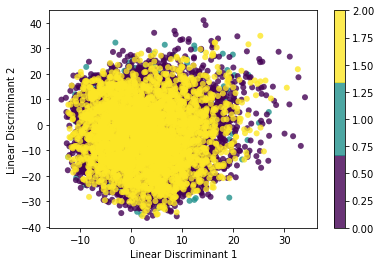

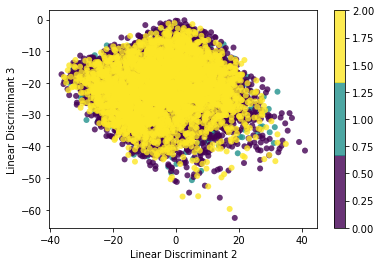

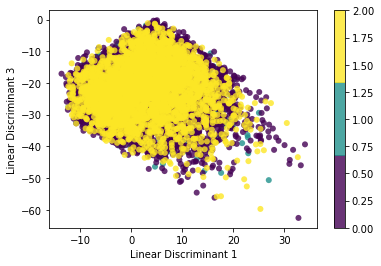

In [2]:
n_components = 3           #Number of Linear Discriminants. Since we have 3 features, n_components may vary from 2 to 3 (since with 1 all samples belong to the same class)
n_features = X.shape[1]    #Number of features
class_labels = np.unique(y)#Classification types. In this case, [0,1,2] 

mean_overall = np.mean(X,axis=0)        #Computation of the mean for each feature
S_W = np.zeros((n_features,n_features)) #Initialization of the covariance matrix among the samples of a same class
S_B = np.zeros((n_features,n_features)) #Initialization of the covariance matrix among the classes

for c in class_labels:
        bol=y == c
        X_c = X[bol[:,0],:]                    #Spliting the data samples according to its classification
        mean_c = np.mean(X_c,axis=0)           #Computation of the mean of each class
        S_W += (X_c- mean_c).T.dot(X_c-mean_c) #Covariance matrix for each class

        n_samples = X.shape[0]                                    #Computing the number of samples
        mean_diff = (mean_c - mean_overall).reshape(n_features,1) #Computing the difference between the overall mean and mean of each class
        S_B += n_samples*mean_diff.dot(mean_diff.T)               #Covariance matrix between the classes
                
A = np.linalg.inv(S_W)@S_B                                        #Computing the matrix (S_w)^{-1}(S_B). Note that as long as ||A|| increases further way the classes become
eigenvalues, eigenvectors = np.linalg.eig(A)                      #Computation of the eigenvalues and eigenvector of A
eigenvectors = eigenvectors.T                                     #Tranposing the eigenvectors
ind = np.argsort(abs(eigenvalues))[::-1]                          #Colleting the index from the larger to the smaller eigenvalues in the eigenvalues matrix
eigenvalues = eigenvalues[ind]                                    #Rewriting the eigenvalues matrix in a decreasing way
eigenvectors = eigenvectors[ind]                                  #Changing the columns of eigenvectors matrix using the same indexes of eigenvalues matrix
linear_discriminants = eigenvectors[0:n_components]               #Obtaining 'n_components' linear discriminants

X_proj = np.dot(X,linear_discriminants.T)                         #Projection of the samples over the linear discriminants matrix

X1 = X_proj[:,0]                                                  #Defining X1 as the first column of X_proj for plot purposes
X2 = X_proj[:,1]                                                  #Defining X2 as the second column of X_proj for plot purposes
X3 = X_proj[:,2]                                                  #Defining X3 as the third column of X_proj for plot purposes


# ------ 3D plot -------------------------                        #3D plot over the three linear discriminants
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = Axes3D(fig)
#c = np.arange(len(X)) / len(X)  # create some colours
#p = ax.scatter(X1, X2, X3, c=y,alpha=0.8, cmap=plt.cm.get_cmap('viridis',3))
#fig.colorbar(p)
#plt.show()

# ------- 2D plots ------------------------
plt.scatter(X1,X2,c=y,edgecolor='none',alpha=0.8,cmap=plt.cm.get_cmap('viridis',3)) #2D plot over the first two linear discriminants
plt.ylabel('Linear Discriminant 2')
plt.xlabel('Linear Discriminant 1')
plt.colorbar()
plt.show()

plt.scatter(X2,X3,c=y,edgecolor='none',alpha=0.8,cmap=plt.cm.get_cmap('viridis',3)) #2D plot over the last two linear discriminants
plt.ylabel('Linear Discriminant 3')
plt.xlabel('Linear Discriminant 2')
plt.colorbar()
plt.show()

plt.scatter(X1,X3,c=y,edgecolor='none',alpha=0.8,cmap=plt.cm.get_cmap('viridis',3)) #2D plot over the first and the last linear discriminants
plt.ylabel('Linear Discriminant 3')
plt.xlabel('Linear Discriminant 1')
plt.colorbar()
plt.show()

## Classification Trees (Random Tree Forests)

### Decision tree learning provides a principled method based on data for creating a predictive model for classification and regression. The decision tree is a hierarchical construct that looks for optimal ways to split the data in order to provide a robust classification and regression. This supervised algorithm stands for making decisions mirroring human decisions, making the classification more interpretable and useful. Thus, this is the second algorithm chosen.

In [3]:
import numpy as np
from collections import Counter                        #Importing collections to count the number of times that each class appears

def entropy(y):                                        #Defining a function to compute the entropy between the classification of each sample
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p*np.log2(p) for p in ps if p>0])

class Node:
    def __init__(self,feature=None, threshold= None, left=None,right=None,*,value=None):
        self.feature = feature                 #Storing the number of features
        self.threshold = threshold             #Storing the thresholds considered to stop the algorithm
        self.left = left                       #Storing the number of left branches
        self.right = right                     #Storing the number of right branches
        self.value = value                     #Storing the values of each leaf
    
    def is_leaf_node(self):
        return self.value is not None          #Verifying if a leaf was found
    
class DecisionTree:
    
    def __init__(self,min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split     #Initializing the minimum number of samples
        self.max_depth = max_depth                     #Initializing the maximum depth of the tree
        self.n_feats = n_feats                         #Initializing the number of features in data matrix
        self.root = None
        
    def fit(self,X,y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats,X.shape[1])  #Defining the number of features
        self.root = self._grow_tree(X,y)                                                 #Calling function _grow_tree
    
    def _grow_tree(self, X,y, depth=0):                                                  
        n_samples, n_features = X.shape                                                  #Getting the number of samples and features from X
        n_labels = len(np.unique(y))                                                     #Getting the possible classes in classifier vector y
        
        if (depth >= self.max_depth                                                      #Conditions to stop the algorithm
            or n_labels == 1
            or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feat_indx = np.random.choice(n_features, self.n_feats, replace=False)            #Chosing indexes to apply in the following functions
    
        best_feat, best_thresh = self._best_criteria(X,y,feat_indx)                      #Computing the best features and the best threshold for the new children branches 
        left_indx, right_indx = self._split(X[:,best_feat], best_thresh)                 # Indexes for the left and right branches
        left = self._grow_tree(X[left_indx,:], y[left_indx], depth+1)                    # Growing the tree to the left
        right = self._grow_tree(X[right_indx,:], y[right_indx], depth+1)                 # Growing the tree to the right
        return Node(best_feat,best_thresh, left, right)                                  # Returning the tree nodes
    
    def _best_criteria(self,X,y,feat_indx):                                              #Function that returns the criteria used in _grow_tree function
        best_gain = -1
        split_indx, split_thresh= None, None                                             #Initializing split_indx and split_thresh
        for feat_indx in feat_indx:
            X_column = X[:,feat_indx]                                                    #Selecting some elements of X associated with some feature
            thresholds = np.unique(X_column)                                             #Computing thresholds
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)                    #Computing the new gains
                
                if gain > best_gain:                                                     #Updating the gains, the indexes and the thresholds
                    best_gain = gain
                    split_indx = feat_indx
                    split_thresh = threshold
                    
        return split_indx, split_thresh

    def _information_gain(self,y,X_column, split_thresh):                                #Computing information gain  (IG)
        parent_entropy = entropy(y)                                                      #Parent node entropy
        left_indx, right_indx = self._split(X_column, split_thresh)                      #Computing left and right indexes
        
        if len(left_indx) == 0 or len(right_indx) == 0:                                  #Verification of the number of left and right indexes
            return 0
        n = len(y)
        n_l, n_r = len(left_indx), len(right_indx)
        e_l, e_r = entropy(y[left_indx]), entropy(y[right_indx])
        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r                                       #child nodes entropies
                           
        ig = parent_entropy - child_entropy                                             #Computation of the Information Gain
        return ig
        
    def _split(self, X_column, split_thresh):                                           #Splitting the nodes to the left and right directions
        left_indx = np.argwhere(X_column<= split_thresh).flatten()
        right_indx = np.argwhere(X_column>= split_thresh).flatten()
        return left_indx, right_indx
    
    def predict(self,X):                                                                #Prediction function
        return np.array([self._traverse_tree(x,self.root) for x in X])
                           
    def _traverse_tree(self,x, node):
        if node.is_leaf_node():                                                         #Traverse function (bottom to top validation)
           return node.value
                           
        if x[node.feature] <= node.threshold:
           return self._traverse_tree(x,node.left)
        return self._traverse_tree(x,node.right)
    
    def _most_common_label(self,y):                                                    #Verification of the most common label
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [8]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import csv

from numpy import genfromtxt
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):                            #Defining a function to verify the performance of the proposed method
    accuracy = np.sum(y_true == y_pred)/len(y_true)      #summing the percentage of the times that the method correctly classify the samples
    return accuracy

y = np.int64(y)                   # Converting y to int64 type
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2) #Splitting the data matrix and the classifier vector in two sets: training samples and test samples

clf = DecisionTree(max_depth=10)   #Defining the maximum number of branches
clf.fit(X1_train,y1_train)         #Training the classifier with the training samples

y1_pred = clf.predict(X1_train)    #Testing the classifier with the test samples
#y1_pred = np.int64(y1_pred)        
acc = accuracy(y1_train,y1_pred)   #Computing the accuracy of the proposed method
print("Accuracy:", acc)   

Accuracy: 0.6105


### Comparing both methods, it is straightforward to note that classification trees provide a broader strategy to the classification, since this method is less prone to erroneous classifications from outliers. In turn, this method is computationally more expensive than LDA, so the classification quality and the computational resources must be considered in the decision. 